In [1]:
import numpy as np
from src.sources.fft import FFTSource
import matplotlib.pyplot as plt

from collections import deque
import cv2
import time
import tkinter as tk
from PIL import Image, ImageTk

import math

from src.visualisers.camera_gui import display

In [2]:
fftsource = FFTSource()
fftsource.start()

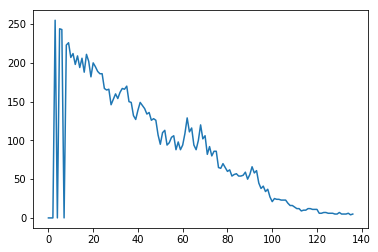

In [3]:
_, data = fftsource.read()
plt.plot(data)

In [4]:
data.shape

(137,)

This shows how to use masks to create an image from a 1D array - https://stackoverflow.com/questions/49188161/how-to-slice-numpy-rows-using-start-and-end-index

In [5]:
array = data[:, None] >= np.arange(256)

In [6]:
array.shape

(137, 256)

In [7]:
blank_image = np.ones(shape=(256, data.shape[0]))*255

In [8]:
blank_image[array.T] = 0

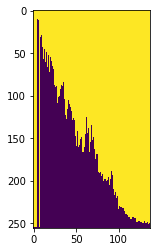

In [9]:
plt.imshow(np.flipud(blank_image))

In [10]:
def convert_to_chart(array, max_value=256, flip=True):
    """Convert 1D numpy array to a chart image.
    
    Args:
        array - 1D numpy with data to convert to plot.
        max_value - maximum value in the array.
        flip - boolean flag to correct the output when positive."""
    # Create a "blank", i.e. white with 255, image array
    blank_image = np.ones(shape=(max_value, array.shape[0]))*255
    # Create a 2D mask from the data
    mask = array[:, None] >= np.arange(max_value)
    # Then flip the mask to align with the image and set to 0 (black)
    blank_image[mask.T] = 0
    # We then just need to flip the output again to get back to the original 
    if flip:
        chart_image = np.flipud(blank_image)
    else:
        chart_image = blank_image
    return chart_image

In [11]:
chart = convert_to_chart(data)

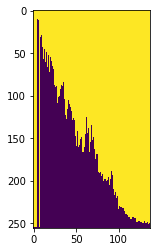

In [12]:
plt.imshow(chart)

In [13]:
pil_image = Image.fromarray(chart)

In [14]:
pil_image.size

(137, 256)

In [15]:
resized = pil_image.resize((512, 256))

In [16]:
resized.size

(512, 256)

We can use a canvas instead of a label. https://stackoverflow.com/questions/32376679/tkinter-canvas-doesnt-show-entire-photo-image.

In [17]:
class AudioGUI:
    
    def __init__(self, sensor=None):
        # Setup gui
        self.window = tk.Tk()
        
        # Setup FPS and Quit Button on First Row
        button_frame = tk.Frame(self.window)
        button_frame.pack(expand=True, fill=tk.BOTH)
        # label for fps
        self.fps_label = tk.Label(button_frame)
        self.fps_label.pack(side=tk.LEFT, padx=5, pady=5)
        self.fps_label._frame_times = deque([0]*5)  # arbitrary 5 frame average FPS
        # quit button
        self.quit_button = tk.Button(button_frame, text='Quit', command=lambda: self.quit_())
        self.quit_button.pack(side=tk.RIGHT, padx=5, pady=5)
        
        # Create a canvas
        self.canvas = tk.Canvas(self.window, width=512, height=256)
        self.canvas.pack(expand=True, fill=tk.BOTH)
        
        """
        # Create a list of panels for the GUI
        self.panels = list()
        # label for the original sound frame - index 0
        original_fft = tk.Label(master=self.window)
        original_fft.pack(expand=True, fill=tk.X)
        self.panels.append(original_fft)
        """
        
        # Setup sensor
        if sensor:
            self.add_sensor(sensor)
        
        self.idFrame = None
        
    def add_sensor(self, sensor):
        """Add a sensor to the GUI for display."""
        self.sensor = sensor
        # Start sensor if not already started
        if not self.sensor.started:
            self.sensor.start()
    
    def update(self):
        # Get audio frame
        _, data = self.sensor.read()
        # Convert to image of histogram
        chart_image = convert_to_chart(data)
        # display(chart_image, self.original_fft)
        pil_image = Image.fromarray(chart_image)
        pil_image = pil_image.resize((512, 256))
        photo_image = ImageTk.PhotoImage(image=pil_image)
        if self.idFrame is None:
            self.idFrame = self.canvas.create_image(0, 0, image=photo_image, anchor=tk.NW)
        else:
            self.canvas.itemconfig(self.idFrame, image=photo_image)
            self.canvas.image = photo_image
        self.window.after(10, self.update)
    
    def run(self):
        self.update()
        self.window.mainloop()
        
    def quit_(self):
        self.sensor.stop()
        self.window.destroy()

In [18]:
a_gui = AudioGUI(fftsource)

ERROR:root:Sampler error occur(l={self.length} and len data={len(data)})


In [19]:
a_gui.run()

In [20]:
_, data = a_gui.sensor.read()

In [21]:
data

array([  0,   0,   0,  26,   0,  67,  86,   0,  58, 106,  89, 112, 115,
       147, 134, 172, 185, 223, 196, 204, 146, 196, 159, 116, 147, 165,
       145, 163, 137, 163, 102, 161, 156, 151, 143, 147, 142, 127, 123,
       125, 132, 146, 132, 130, 128, 140, 113, 106,  98, 103,  98, 107,
        96,  89,  80, 116, 123, 101,  98,  98, 120, 114, 134, 119, 110,
       104,  96, 111, 127, 115, 127, 108, 139, 118, 119, 117,  93,  96,
        96,  81,  71,  79,  79,  65,  70,  62,  72,  78,  84,  69,  67,
        56,  57,  48,  51,  52,  49,  43,  46,  39,  33,  35,  32,  29,
        27,  27,  25,  22,  22,  23,  21,  18,  18,  19,  18,  20,  19,
        21,  15,  19,  18,  14,  15,  13,  14,  13,  14,  14,  12,  12,
        12,  12,  13,  12,  12,  12,  11], dtype=uint8)

In [22]:
from src.visualisers.audio_gui import AudioGUI as AG

a_gui_2 = AG(fftsource)

ERROR:root:Sampler error occur(l={self.length} and len data={len(data)})


In [26]:
a_gui_2

## Mean Buffers

Let's have a look at how the mean of the audio changes with different time periods.

In [23]:
class MeanBuffer:
    """This is similar to our sensor and buffer objects."""
    
    def __init__(self, vec_len, time_period):
        """Initialise.
        
        Args:
            time_period - integer period over which to determine the mean.
        """
        self.time_period = time_period
        self.count = 0
        self.running_sum = np.zeros(shape=(vec_len, 1))
        self.buffered_mean = np.zeros(shape=(vec_len, 1))
        
    def iterate(self, input_data):
        """Iterate using input_data."""
        self.count += 1
        self.running_sum += input_data
        # If end of period
        if (self.count) % self.time_period == 0:
            # Replace old buffered mean with new mean
            self.buffered_mean = self.running_sum / self.time_period
            # Reset running sum
            self.running_sum.fill(0)
            # Reset count
            self.count = 0
    
    @property
    def mean(self):
        """Return mean."""
        # If no buffered mean
        if (self.buffered_mean == 0).all():
            mean = (self.running_sum / self.count).astype(np.int16)
        else:
            mean = self.buffered_mean.copy().astype(np.int16)
        return mean
    
    def __repr__(self):
        """Print output."""
        return mean

In [24]:
class MeanAudioGUI:
    
    def __init__(self, sensor, num_of_buffers=8, group_size=2):
        # Setup gui
        self.window = tk.Tk()
        
        # Setup FPS and Quit Button on First Row
        button_frame = tk.Frame(self.window)
        button_frame.pack(expand=True, fill=tk.BOTH)
        # quit button
        self.quit_button = tk.Button(button_frame, text='Quit', command=lambda: self.quit_())
        self.quit_button.pack(side=tk.RIGHT, padx=5, pady=5)
        
        # Create a list of panels for the GUI
        self.panels = list()
        self.canvas_content = list()
        for i in range(num_of_buffers):
            # Create a canvas for each panel
            canvas = tk.Canvas(self.window, width=512, height=64)
            canvas.pack(expand=True, fill=tk.BOTH)
            self.panels.append(canvas)
            self.canvas_content.append(None)
                         
        # Setup sensor
        self.add_sensor(sensor)
        _, data = sensor.read()
        
        # Create mean buffers
        self.num_of_buffers = num_of_buffers
        self.mean_buffers = [MeanBuffer(data.shape[0], group_size**i) for i in range(num_of_buffers)]
        
    def add_sensor(self, sensor):
        """Add a sensor to the GUI for display."""
        self.sensor = sensor
        # Start sensor if not already started
        if not self.sensor.started:
            self.sensor.start()
    
    def update(self):
        # Get audio frame
        _, data = self.sensor.read()
        input_data = data.reshape(-1, 1)
        # Iterate through buffers in reverse
        for mb in reversed(self.mean_buffers):
            mb.iterate(input_data)
            input_data = input_data - mb.mean
        
        # Display the mean values of each buffer
        for i in range(self.num_of_buffers):
            # Convert to image of histogram
            mean = self.mean_buffers[i].mean.ravel()
            positive_chart_image = convert_to_chart(mean)
            negative_chart_image = convert_to_chart(-1*mean, flip=False)
            chart_image = np.concatenate([positive_chart_image, negative_chart_image], axis=0)
            # display(chart_image, self.original_fft)
            pil_image = Image.fromarray(chart_image)
            pil_image = pil_image.resize((512, 64))
            photo_image = ImageTk.PhotoImage(image=pil_image)
            if self.canvas_content[i] is None:
                # print("Creating chart")
                self.canvas_content[i] = self.panels[i].create_image(0, 0, image=photo_image, anchor=tk.NW)
            else:
                # print("Configuring chart")
                self.panels[i].itemconfig(self.canvas_content[i], image=photo_image)
                self.panels[i].image = photo_image
                
        self.window.after(30, self.update)
    
    def run(self):
        self.update()
        self.window.mainloop()
        
    def quit_(self):
        self.sensor.stop()
        self.window.destroy()

In [25]:
m = MeanAudioGUI(fftsource, group_size=4)

ERROR:root:Sampler error occur(l={self.length} and len data={len(data)})


In [26]:
m.run()

/home/ben/anaconda3/envs/var_processor/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
m.mean_buffers[0].mean.shape

Todo:
* ~~Change scale to incorporate negative values.~~
* Scale based on maximum over time.

Observations:
* Certain patterns show up at different scales. E.g. chord changes and beat show up later in the means.
* Lowest few don't show much variation - things happen in the short term.

## Adapting convert_to_chart for negative values

Easiest way is to create two charts - one for negative and one for positive and then graft them together.

Can you just pass a negative version of the array to convert to chart? Then concatenate both along axis=0? Yes.

## Looking at Scales and PBT

We could do with a "panel" class to display each layer of the mean.

## Quick Eigenvalue Decomposition

We can use our trick for 2 and 4 decompositions - shifting then adding or subtracting.

We can have a quick function to do this in 1D.

We can generate a 2D spectrogram from the FFT by buffering over 256 samples, then decompose as per the image. See the bottom of this notebook - https://github.com/benhoyle/predictive_coding/blob/master/2019-07-26%20-%20PCA%20of%20Binary%20Images%20in%20Space%20***.ipynb.

In [2]:
# This is our function for 2D images
def decompose(image):
    """Decompose an image using the Hadamard transform."""
    H = image[1:,:] - image[:-1,:]
    V = image[:,1:] - image[:,:-1]
    # Work out top TLHC + BRHC
    d_1 = image[:-1,:-1] + image[1:,1:]
    # Then work out BLHC + TLHC
    d_2 = image[1:,:-1] + image[:-1,1:]
    D = d_1 - d_2
    # Average is sum of four shifted versions
    A = image[:-1,:-1] + image[1:,:-1] + image[:1,-1] + image[1:,1:]
    return [A, H, V, D]

In [3]:
fft_256 = FFTSource(res_factor=2)
fft_256.start()

In [12]:
_, data = fft_256.read()
data.shape

(274,)

We could do with making this in factors of 2...

In [13]:
from src.sources.fft import midi_tune

In [16]:
sample_freq=44100
nb_samples=65536
res_factor=1
sample_loc = np.linspace(
            10,
            sample_freq // 2,
            nb_samples // 2,
            dtype=np.uint16
)
sample_loc.shape     

(32768,)

In [17]:
sample_loc.max()

22050

In [18]:
# Use midi_tune to convert to log scale
log_sample_loc = midi_tune(sample_loc)
log_sample_loc.shape  

(32768,)

In [19]:
log_sample_loc.max()

136.76557586169105

The length comes from the bin count...

fft_y_data is of length 32768 - same as log_sample_loc / x_scale

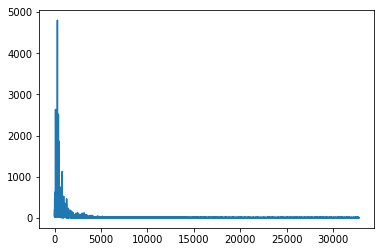

In [75]:
from scipy.fftpack import fft
self = fft_256
with self.read_lock:
    samples = np.asarray(self._s_fifo, dtype=np.int16)
    y_freq = fft(samples)

fft_y_data = (
                (1.0 / (self.nb_samples / 2)) *
                np.abs(y_freq[0:self.nb_samples // 2])
            )
plt.plot(fft_y_data)

In [76]:
fft_y_data.max()

4800.758648727297

In [77]:
fft_y_data.dtype, fft_y_data.shape

(dtype('float64'), (32768,))

In [78]:
# fft_y_data = np.ones(32768)

            # Use bincount to get the sum for each unique x, and
            # divide each sum by the count of each unique value in x

fft_y_data2 = np.bincount(log_sample_loc.astype(np.uint16), weights=fft_y_data)
output = fft_y_data2 / (np.bincount(log_sample_loc.astype(np.uint16))+0.0001)

In [79]:
np.bincount(log_sample_loc.astype(np.uint16))

array([   0,    0,    0,    2,    0,    1,    2,    0,    1,    2,    1,
          2,    1,    2,    1,    2,    1,    3,    2,    1,    3,    3,
          2,    3,    3,    3,    3,    4,    3,    5,    2,    5,    4,
          6,    5,    6,    6,    6,    6,    7,    7,    8,    7,    9,
          9,   11,   10,   10,   12,   12,   14,   13,   15,   15,   16,
         18,   18,   21,   19,   22,   24,   24,   26,   27,   30,   30,
         32,   36,   36,   40,   40,   45,   46,   49,   52,   55,   58,
         61,   65,   70,   73,   79,   81,   88,   92,   99,  104,  110,
        116,  123,  131,  140,  145,  156,  165,  176,  184,  196,  209,
        220,  231,  247,  262,  278,  293,  312,  330,  349,  369,  393,
        416,  440,  465,  494,  523,  555,  587,  623,  660,  699,  739,
        785,  831,  880,  932,  987, 1047, 1109, 1174, 1246, 1319, 1398,
       1479, 1568, 1662, 1761, 1417])

In [80]:
np.bincount(log_sample_loc.astype(np.uint16))[30]

2

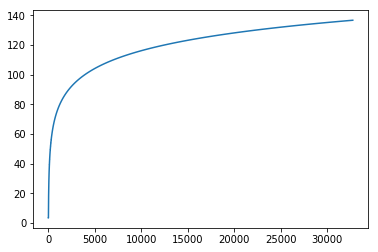

In [81]:
plt.plot(log_sample_loc)

In [82]:
fft_y_data2 

array([    0.        ,     0.        ,     0.        ,   169.37380086,
           0.        ,   101.45269804,   217.55028911,     0.        ,
          33.21393752,   288.62973164,   127.98708644,   100.9065456 ,
          84.37053161,   196.99304581,   258.5039207 ,   758.73568835,
         293.93045547,   693.1000804 ,   598.01622697,   233.11953461,
         253.75840319,   634.90170595,   371.0166567 ,   347.43539852,
         386.0973164 ,   185.88265071,   500.52828349,   356.83401009,
         130.55071678,   476.28908287,   268.63799618,   773.40395137,
         561.46141662,   683.7089688 ,  1788.02654889,   833.44073559,
         739.48316644,   655.62965816,   903.35264805,  4478.78260668,
        2454.55154179,  1273.64416399,  1323.25094921,  1318.25661387,
        1851.23739814,  2087.79404038,  1440.4363486 ,  1836.43656266,
        1506.9972399 ,  4874.13954596, 14871.35154159, 13833.15533715,
       16547.92002761,  5924.20958677,  5443.07909122, 10566.41884185,
      

In [126]:
fft_y_data2.shape, fft_y_data2.dtype, fft_y_data2.min(), fft_y_data2.max()

((137,), dtype('float64'), 0.0, 29362.702645877896)

In [84]:
fft_y_data2.argmax()

56

In [56]:
fft_y_data2[56]

29362.702645877896

In [58]:
log_sample_loc.astype(np.uint16)[50:60]

array([28, 29, 29, 29, 29, 29, 30, 30, 31, 31], dtype=uint16)

In [60]:
log_sample_loc.astype(np.uint16)[:58]

array([ 3,  3,  5,  6,  6,  8,  9,  9, 10, 11, 11, 12, 13, 13, 14, 15, 15,
       16, 17, 17, 17, 18, 18, 19, 20, 20, 20, 21, 21, 21, 22, 22, 23, 23,
       23, 24, 24, 24, 25, 25, 25, 26, 26, 26, 27, 27, 27, 27, 28, 28, 28,
       29, 29, 29, 29, 29, 30, 30], dtype=uint16)

So 56 and 57 would be mapped to 30. The bin count would have out[30] += fft[56], out[30] += fft[57]

In [61]:
np.unique(log_sample_loc.astype(np.uint16)[:58])

array([ 3,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30], dtype=uint16)

In [63]:
np.unique(log_sample_loc.astype(np.uint16)[:58])[25]

30

So this would be the 25th entry in the output. No the bincount is a linear scale including values with 0.

So 0s aren't really 0s - they are just where the integer values don't sync up. But there are only a few values initially.

Ah so divide by bincount gives the average if the weights provide a sum for each integer value?

In [67]:
fft_y_data2[-1417:].sum()

579236.6962657231

In [68]:
fft_y_data2[-1417:].sum() / 1417

408.7767792983226

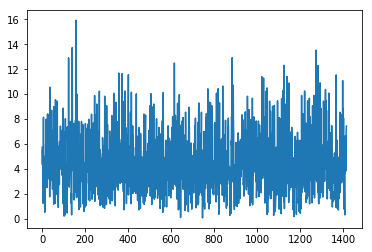

In [90]:
plt.plot(fft_y_data[-1417:])

So the values may vary quite a bit so the mean may not.

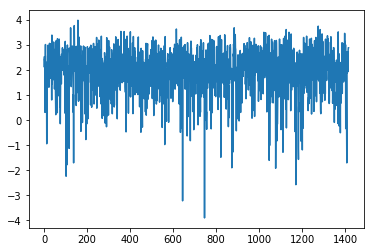

In [89]:
plt.plot(np.log2(fft_y_data[-1417:]))

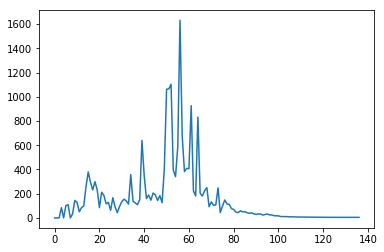

In [70]:
plt.plot(output)

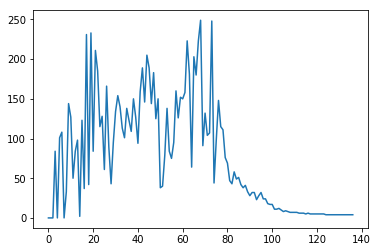

In [71]:
plt.plot(output.astype(np.uint8))

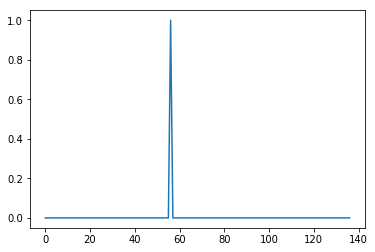

In [72]:
plt.plot(norm_scale(output).astype(np.uint8))

Ah hence the issue!

Still doesn't explain why the value at 30 os not the average of 21741 as indicated below? Ah it is because the 56th entry in the bincount function is 29000 - but this contains thousands of entries, so the average is lower.

/home/ben/anaconda3/envs/var_processor/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.


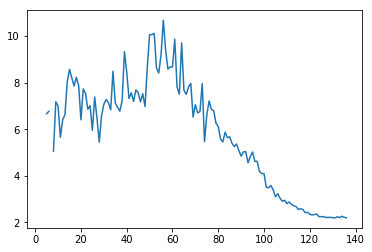

In [87]:
plt.plot(np.log2(output))

So we could take the log2 of the fft bincounted values (or the original FFT values)?

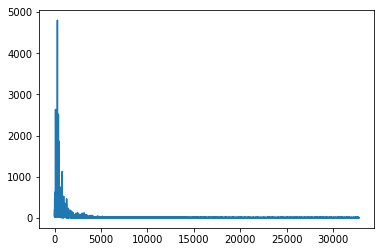

In [175]:
with self.read_lock:
    samples = np.asarray(self._s_fifo, dtype=np.int16)
    y_freq = fft(samples)

fft_y_data = (
                (1.0 / (self.nb_samples / 2)) *
                np.abs(y_freq[0:self.nb_samples // 2])
            )
plt.plot(fft_y_data)

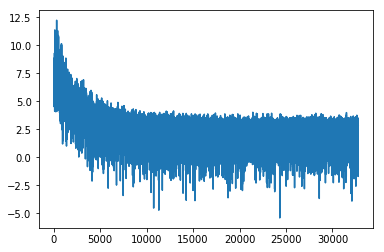

In [92]:
plt.plot(np.log2(fft_y_data))

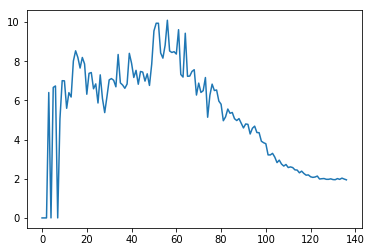

In [118]:
fft_biny_data_logged = np.bincount(log_sample_loc.astype(np.uint16), weights=np.log2(fft_y_data))
output = fft_biny_data_logged / (np.bincount(log_sample_loc.astype(np.uint16))+0.0001)
plt.plot(output)

In [119]:
output

array([ 0.        ,  0.        ,  0.        ,  6.40373024,  0.        ,
        6.66399702,  6.73944213,  0.        ,  5.05321154,  7.0087867 ,
        6.99915453,  5.59845605,  6.39802748,  6.17456736,  8.01324103,
        8.5337682 ,  8.19851119,  7.65381639,  8.1942172 ,  7.86413968,
        6.31649206,  7.38293308,  7.42437908,  6.5963545 ,  6.84434369,
        5.86916797,  7.30601522,  6.0937124 ,  5.37859603,  6.18922105,
        7.04974896,  7.11549665,  7.02903061,  6.69611264,  8.34688554,
        6.89667087,  6.78753946,  6.61995367,  6.83776347,  8.40545349,
        7.89927435,  7.17334369,  7.53684188,  6.82678902,  7.47887963,
        7.44697635,  6.98741575,  7.35969555,  6.76603887,  7.84956431,
        9.54984115,  9.94244652,  9.94168933,  8.42569182,  8.16017455,
        8.8200592 , 10.09536014,  8.52780569,  8.44857101,  8.49051004,
        8.36884695,  9.61329872,  7.32525225,  7.19304832,  9.43153789,
        7.23263098,  7.24307668,  7.4811035 ,  7.5698381 ,  6.27

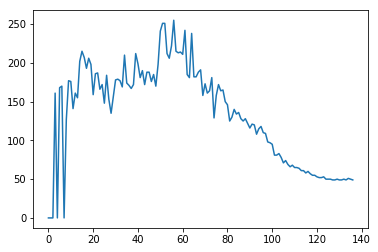

In [121]:
integered = (norm_scale(output)*255).astype(np.uint8)
plt.plot(integered)

In [122]:
integered

array([  0,   0,   0, 161,   0, 168, 170,   0, 127, 177, 176, 141, 161,
       155, 202, 215, 207, 193, 206, 198, 159, 186, 187, 166, 172, 148,
       184, 153, 135, 156, 178, 179, 177, 169, 210, 174, 171, 167, 172,
       212, 199, 181, 190, 172, 188, 188, 176, 185, 170, 198, 241, 251,
       251, 212, 206, 222, 255, 215, 213, 214, 211, 242, 185, 181, 238,
       182, 182, 188, 191, 158, 173, 161, 164, 181, 129, 158, 172, 164,
       165, 150, 146, 125, 130, 140, 134, 136, 128, 125, 128, 122, 116,
       121, 120, 108, 115, 118, 110, 109,  98,  97,  95,  81,  81,  83,
        78,  71,  74,  69,  66,  68,  65,  65,  64,  61,  61,  58,  60,
        57,  55,  55,  53,  52,  52,  53,  50,  50,  50,  49,  49,  50,
        49,  49,  50,  49,  51,  50,  49], dtype=uint8)

See here for previous work on this - https://github.com/benhoyle/predictive_coding/blob/master/2019-10-08%20-%20PCA%20Audio%20Processing%20Pipeline%20***.ipynb

In [100]:
midi_scaled = midi_tune(fft_y_data)

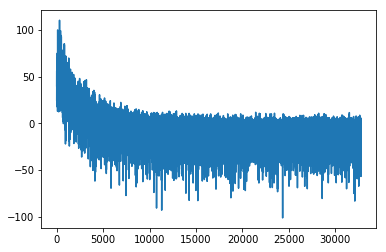

In [101]:
plt.plot(midi_scaled)

No that doesn't work but we get a similar curve.

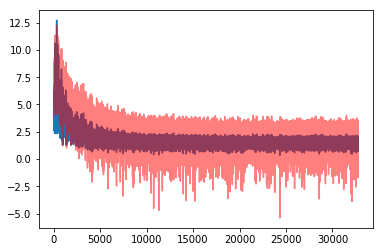

In [107]:
fft_scaled = fft_y_data**0.3
plt.plot(fft_scaled)
plt.plot(np.log2(fft_y_data), 'r', alpha=0.5)

Fairly similar whether we just log or scale by f^0.3. But better range of values for the log.

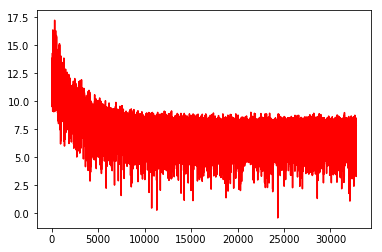

In [108]:
plt.plot(np.log2(fft_y_data)+5, 'r')

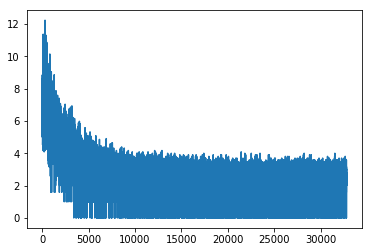

In [116]:
plt.plot(np.log2(fft_y_data.astype(np.uint16)+1))

We can clip the values as an alternative to rounding. Again we might need to check for 0 (or add a small factor).

Adding a small factor of 1 might work out the best.

/home/ben/anaconda3/envs/var_processor/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until


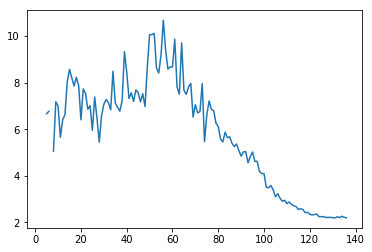

In [95]:
fft_biny_data_notlogged = np.bincount(log_sample_loc.astype(np.uint16), weights=fft_y_data)
output2 = fft_biny_data_notlogged / (np.bincount(log_sample_loc.astype(np.uint16))+0.0001)
plt.plot(np.log2(output2))

Seems better to log2 after we've computed the output - but if we log2 the fft data we avoid divide by 0.

We need our previous methods to only log the non-zero values.

In [88]:
np.log2(30000)

14.872674880270605

In [59]:
(fft_y_data2[56]+fft_y_data2[57])/2

21741.866068422605

In [53]:
output.shape, output.dtype, output.min(), output.max()

((137,), dtype('float64'), 0.0, 1631.25219559213)

***Ah HERE IS THE ISSUE - the output has a max > 255***

https://numpy.org/doc/stable/reference/generated/numpy.bincount.html

We could use minlength - but the last half of values would be empty...

Let's just check this is right. fft_y_data is length 32768 and each value corresponds to a different frequency.

In [49]:
y_freq.shape

(65536,)

midi_tune sets the number of values.

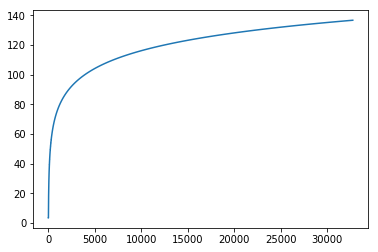

In [52]:
plt.plot(log_sample_loc)

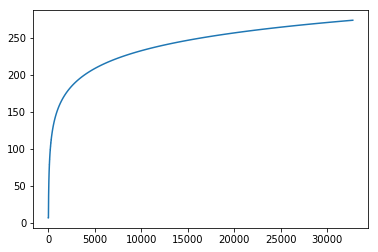

In [53]:
plt.plot(log_sample_loc*2)

In [45]:
fft_y_data

array([0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
       2.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
       1.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 3.000e+00,
       2.000e+00, 1.000e+00, 3.000e+00, 3.000e+00, 2.000e+00, 3.000e+00,
       3.000e+00, 3.000e+00, 3.000e+00, 4.000e+00, 3.000e+00, 5.000e+00,
       2.000e+00, 5.000e+00, 4.000e+00, 6.000e+00, 5.000e+00, 6.000e+00,
       6.000e+00, 6.000e+00, 6.000e+00, 7.000e+00, 7.000e+00, 8.000e+00,
       7.000e+00, 9.000e+00, 9.000e+00, 1.100e+01, 1.000e+01, 1.000e+01,
       1.200e+01, 1.200e+01, 1.400e+01, 1.300e+01, 1.500e+01, 1.500e+01,
       1.600e+01, 1.800e+01, 1.800e+01, 2.100e+01, 1.900e+01, 2.200e+01,
       2.400e+01, 2.400e+01, 2.600e+01, 2.700e+01, 3.000e+01, 3.000e+01,
       3.200e+01, 3.600e+01, 3.600e+01, 4.000e+01, 4.000e+01, 4.500e+01,
       4.600e+01, 4.900e+01, 5.200e+01, 5.500e+01, 5.800e+01, 6.100e+01,
       6.500e+01, 7.000e+01, 7.300e+01, 7.900e+01, 

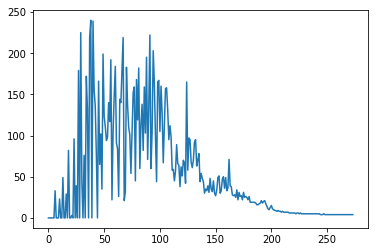

In [59]:
plt.plot(data)

In [60]:
data[256:]

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=uint8)

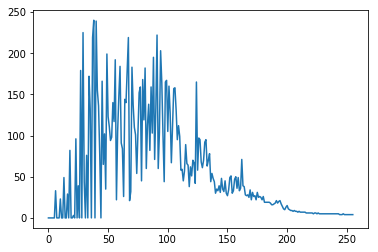

In [61]:
plt.plot(data[:256])

I can possibly just cut the last set of values...probably easier!

In [67]:
import math

In [68]:
int(math.log(274, 4))

4

In [71]:
(4, )*3

(4, 4, 4)

What we could have is:
* Original image on LHS. Then the 4 decompositions.
* Plus a stack of the "average" images with sampling. 

These are different aspects of our previous "SpaceTime" grid.

Ah - it gets more complicated than the mean because we also need to subsample in time. Hence our modulo vec_len (4) check.

In [73]:
num_of_buffers = 4
for i in range(num_of_buffers+1):
    print( 256 // (4**i) )

256
64
16
4
1


In [74]:
# Check component size
zeros = np.zeros(shape=(256, 256))
components = decompose(zeros)
for c in components:
    print(c.shape)

(255, 255)
(255, 256)
(256, 255)
(255, 255)


In [4]:
# These are from the timebuffer file - we have converted to 1D input data and a 2D case
def add_to_array(array, frame):
    """Add a frame to a rolling array."""
    array = np.roll(array, -1, axis=1)
    # Add frame to end of buffer
    array[..., -1] = frame
    return array

class Buffer:
    """Object for a time buffer."""

    def __init__(self, data_length, time_length):
        """Initialise object.

        Assumes 8-bit values (for now).
        """
        # Set up an array to store a rolling window of inputs
        self.array = np.zeros(
            shape=(data_length, time_length), dtype=np.int16)

    def add(self, frame):
        """Add a frame to the buffer in FF mode."""
        self.array = add_to_array(self.array, frame)
        return None

    @property
    def latest(self):
        """Return latest entry in buffer."""
        return self.forward_array[..., -1]



In [5]:
def norm_scale(a):
    """Normalise array to a scale of 0 to 1."""
    return (a - np.min(a))/np.ptp(a)

In [10]:
class SpectrogramGUI:
    
    def __init__(self, sensor, vec_len=4, run=True):
        # Setup gui
        self.window = tk.Tk()
        
        # Setup FPS and Quit Button on First Row
        button_frame = tk.Frame(self.window)
        button_frame.pack(expand=True, fill=tk.BOTH)
        # quit button
        self.quit_button = tk.Button(button_frame, text='Quit', command=lambda: self.quit_())
        self.quit_button.pack(side=tk.RIGHT, padx=5, pady=5)
        
        # Create a list of panels for the GUI
        self.panels = list()
        self.canvas_content = list()
        # We have an extra canvas for the original data
        for i in range(vec_len+1):
            # Create a canvas for each panel
            canvas = tk.Canvas(self.window, width=256, height=256)
            canvas.pack(side=tk.LEFT)
            self.panels.append(canvas)
            self.canvas_content.append(None)
                         
        # Setup sensor
        self.add_sensor(sensor)
        _, data = sensor.read()
        
        self.vec_len = vec_len        
        # Determine the number of buffers based on data length and vec_len
        self.num_of_buffers = int(math.log(data.shape[0], vec_len))
        # We can crop the data to a factor of vec_len
        self.cropped_data_length = vec_len**self.num_of_buffers
        # Start with a single cuboid buffer that is decomposed
        self.buffer = Buffer(self.cropped_data_length, self.cropped_data_length)
        """
        # Create buffers - set as cuboid
        self.buffers = list()                          
        for i in range(num_of_buffers):
            buffer_size = self.cropped_data_length // (vec_len**i)
            # But
            self.buffers.append(Buffer((buffer_size, )*3))
        """
        if run:
            self.run()
        
    def add_sensor(self, sensor):
        """Add a sensor to the GUI for display."""
        self.sensor = sensor
        # Start sensor if not already started
        if not self.sensor.started:
            self.sensor.start()
    
    def update(self):
        # Get audio frame
        _, data = self.sensor.read()
        input_data = data[:self.cropped_data_length].reshape(-1, 1)
        # Add to buffer
        self.buffer.add(input_data.ravel())
        # Get buffer image
        image = self.buffer.array
        # Decompose
        components = decompose(image)
        print([c.dtype for c in components])
        # Now the first component (A) will have a max of 255*4, with the others having a range of -2*255-2*255
        """
        components[0] = components[0] / self.vec_len
        for c in components[1:]:
            c = (c + 2*255) // self.vec_len
        """
        # Normalise each component
        for c in components:
            c = norm_scale(c)*255
            print(c.max(), c.min(), c.dtype)
        """                          
        # Iterate through buffers in reverse
        for buffer in self.buffers:
            buffer.add(input_data)
            # Get image from buffer
            image = buffer.array
            # Average is sum of four shifted versions - specific to vec_len = 4
            A = image[:-1,:-1] + image[1:,:-1] + image[:1,-1] + image[1:,1:]                       
            input_data = A[::self.vec_len]
        """
        # Group images in one list and scale components
        images_for_display = [image.astype(np.uint8)] + [c.astype(np.uint8) for c in components]
        # images_for_display = [image] + components
        # Display the mean values of each buffer
        for i, image in enumerate(images_for_display):
            print(i, image.max(), image.min(), image.dtype)
            pil_image = Image.fromarray(image)
            pil_image = pil_image.resize((256, 256))
            photo_image = ImageTk.PhotoImage(image=pil_image)
            if self.canvas_content[i] is None:
                # print("Creating chart")
                self.canvas_content[i] = self.panels[i].create_image(0, 0, image=photo_image, anchor=tk.NW)
            else:
                # print("Configuring chart")
                self.panels[i].itemconfig(self.canvas_content[i], image=photo_image)
                self.panels[i].image = photo_image
                
        self.window.after(30, self.update)
    
    def run(self):
        self.update()
        self.window.mainloop()
        
    def quit_(self):
        self.sensor.stop()
        self.window.destroy()

In [11]:
sg = SpectrogramGUI(fft_256)

ERROR:root:Sampler error occur(l={self.length} and len data={len(data)})


[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 251 0 uint8
1 251 0 uint8
2 255 0 uint8
3 251 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 253 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 f

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
2

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0 uint8
3 255 0 uint8
4 255 0 uint8
[dtype('int16'), dtype('int16'), dtype('int16'), dtype('int16')]
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
255.0 0.0 float64
0 255 0 uint8
1 255 0 uint8
2 255 0

In [19]:
_, data = fft_256.read()

In [20]:
data.max()

254

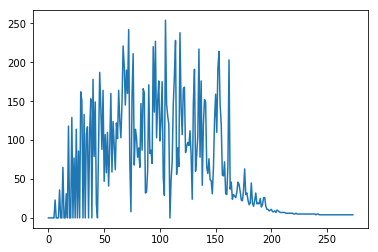

In [21]:
plt.plot(data)

Awesome!

BUT WE HAVE OVERFLOW IN SOME - we need to convert to int16. This might be in the FFT computation...as it appears to occur as a peak builds over time.

Theres the computation - ```fft_y_data = fft_y_data.astype(np.uint8)``` in the FFT source code - is this where the clipping may be occurring?

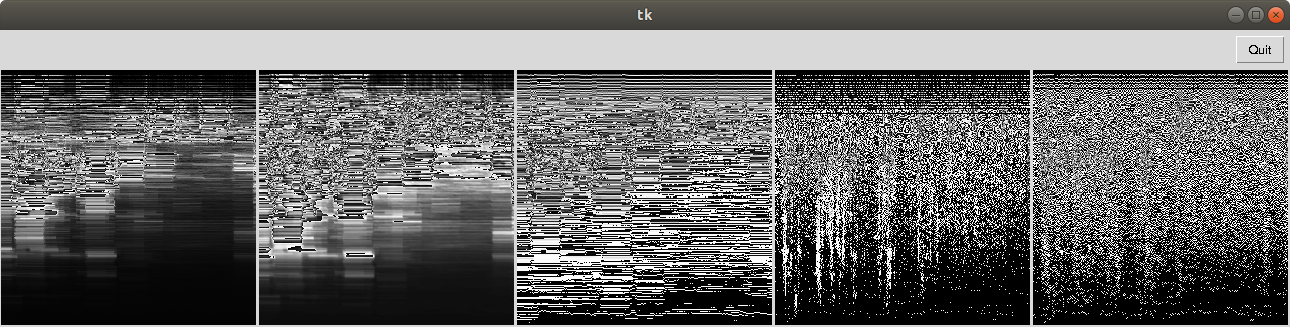

Observations:
* Diagonal appears noiselike and not really containing useful information? Wonder what the eigenvalue is...
* Again the average is informationally not that useful...
* It seems that we take the average and then decompose this at each level into H and V.
* The vertical information is time localised - you get vertical lines for speech. So is the horizontal - words are uniform sized horizontal extends. If we average in time too much would this information get lost? Ah but if we subtracted the lower level estimate the short term features may be enhanced. So the value is not the signal per se but the difference.
* We might need to renormalise the average data - to put it in a range of 0 to 255 as the averaging will naturally cause the values to decrease.

How would we add another row to this?

We can take the average image and also average over time.



***TO DO***

Change the FFTSource to use the log2 of the fft, with a small addition of 1 to prevent log2(0).

fft_biny_data_logged = np.bincount(log_sample_loc.astype(np.uint16), weights=np.log2(fft_y_data))
output = fft_biny_data_logged / (np.bincount(log_sample_loc.astype(np.uint16))+0.0001)
integered = (norm_scale(output)*255).astype(np.uint8)

In [123]:
%%timeit

np.log2(fft_y_data)

476 µs ± 7.82 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [125]:
%%timeit

np.log2(fft_y_data.astype(np.uint16)+1)

263 µs ± 1.36 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [127]:
%%timeit

np.log2(fft_y_data2.astype(np.uint16)+1)

5.51 µs ± 26.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [128]:
%%timeit
fft_biny_data_notlogged = np.bincount(log_sample_loc.astype(np.uint16), weights=fft_y_data)
output = fft_biny_data_notlogged / (np.bincount(log_sample_loc.astype(np.uint16))+1) 
integered = (norm_scale(np.log2(output))*255).astype(np.uint8)

/home/ben/anaconda3/envs/var_processor/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ben/anaconda3/envs/var_processor/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ben/anaconda3/envs/var_processor/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


319 µs ± 10.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [130]:
%%timeit
fft_biny_data_logged = np.bincount(log_sample_loc.astype(np.uint16), weights=np.log2(fft_y_data))
output = fft_biny_data_logged / (np.bincount(log_sample_loc.astype(np.uint16))+1) 
integered = (norm_scale(output)*255).astype(np.uint8)

749 µs ± 9.64 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Twice as long if we log the weights. Better to log as late as possible on the lower dimension data.

In [134]:
%%timeit
samples = log_sample_loc.astype(np.uint16)
fft_biny_data_notlogged = np.bincount(samples, weights=fft_y_data)
output = fft_biny_data_notlogged // (np.bincount(samples)+1) 
integered = (norm_scale(np.log2(output+0.01))*255).astype(np.uint8)

293 µs ± 9.05 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [148]:
%%timeit
samples = log_sample_loc.astype(np.uint16)
fft_biny_data_notlogged = np.bincount(samples, weights=fft_y_data)
output = fft_biny_data_notlogged / (np.bincount(samples)+1) 
integered = (norm_scale(np.log2(output+1))*255).astype(np.uint8)

281 µs ± 1.18 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


The code above is the quickest.

In [149]:
%%timeit
samples = log_sample_loc.astype(np.uint16)
fft_biny_data_notlogged = np.bincount(samples, weights=fft_y_data)
output = fft_biny_data_notlogged / (np.bincount(samples)+1) 
integered = (np.clip(np.log2(output+1), 0, 15)*255).astype(np.uint8)

256 µs ± 1.99 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [176]:
samples = log_sample_loc.astype(np.uint16)
fft_biny_data_notlogged = np.bincount(samples, weights=fft_y_data)
output = fft_biny_data_notlogged / (np.bincount(samples)+1) 
integered = (np.clip(np.log2(output+1), 0, 15)*255).astype(np.uint8)

In [177]:
output

array([   0.        ,    0.        ,    0.        ,   56.45793362,
          0.        ,   50.72634902,   72.51676304,    0.        ,
         16.60696876,   96.20991055,   63.99354322,   33.6355152 ,
         42.1852658 ,   65.6643486 ,  129.25196035,  252.91189612,
        146.96522773,  173.2750201 ,  199.33874232,  116.55976731,
         63.4396008 ,  158.72542649,  123.6722189 ,   86.85884963,
         96.5243291 ,   46.47066268,  125.13207087,   71.36680202,
         32.63767919,   79.38151381,   89.54599873,  128.90065856,
        112.29228332,   97.67270983,  298.00442481,  119.06296223,
        105.64045235,   93.66137974,  129.05037829,  559.84782584,
        306.81894272,  141.51601822,  165.40636865,  131.82566139,
        185.12373981,  173.9828367 ,  130.94875896,  166.94877842,
        115.92286461,  374.93381123,  991.42343611,  988.08252408,
       1034.24500173,  370.26309917,  320.18112301,  556.12730747,
       1545.40540241,  641.86497686,  363.3058462 ,  390.82418

In [151]:
np.log2(1.94), np.log2(1.94+1), np.log2(1)

(0.9560566524124029, 1.5558161550616396, 0.0)

Old integered
```array([  0,   0,   0, 161,   0, 168, 170,   0, 127, 177, 176, 141, 161,
       155, 202, 215, 207, 193, 206, 198, 159, 186, 187, 166, 172, 148,
       184, 153, 135, 156, 178, 179, 177, 169, 210, 174, 171, 167, 172,
       212, 199, 181, 190, 172, 188, 188, 176, 185, 170, 198, 241, 251,
       251, 212, 206, 222, 255, 215, 213, 214, 211, 242, 185, 181, 238,
       182, 182, 188, 191, 158, 173, 161, 164, 181, 129, 158, 172, 164,
       165, 150, 146, 125, 130, 140, 134, 136, 128, 125, 128, 122, 116,
       121, 120, 108, 115, 118, 110, 109,  98,  97,  95,  81,  81,  83,
        78,  71,  74,  69,  66,  68,  65,  65,  64,  61,  61,  58,  60,
        57,  55,  55,  53,  52,  52,  53,  50,  50,  50,  49,  49,  50,
        49,  49,  50,  49,  51,  50,  49], dtype=uint8)```

In [178]:
np.log2(output+1)

array([ 0.        ,  0.        ,  0.        ,  5.8444342 ,  0.        ,
        5.69282746,  6.20000134,  0.        ,  4.13807465,  6.6030315 ,
        6.0222245 ,  5.11418023,  5.43246726,  6.05884352,  7.02516128,
        7.98818418,  7.20911437,  7.44522198,  7.64629763,  6.8772506 ,
        6.00987565,  7.31945018,  6.96199621,  6.4571157 ,  6.60769026,
        5.56896428,  6.97879134,  6.17725611,  5.07200627,  6.32879184,
        6.50057898,  7.02126493,  6.82390579,  6.62457922,  8.22402302,
        6.90764736,  6.73661099,  6.56470405,  7.02292679,  9.13146557,
        8.26593821,  7.15498027,  7.37856684,  7.05339009,  7.54011827,
        7.45106961,  7.04383397,  7.39187749,  6.86941327,  8.55433487,
        9.95481199,  9.94994709, 10.01575652,  8.53629812,  8.32724329,
        9.12186322, 10.59470287,  9.32837194,  8.50900634,  8.61406264,
        8.61065702,  9.79836211,  7.75632415,  7.45731007,  9.65532194,
        7.63135901,  7.45766315,  7.77420446,  7.93130712,  6.50

In [183]:
integered = ((np.clip(np.log2(output+1), 2, 12)-2)*(255/10)).astype(np.uint8); integered

array([  0,   0,   0,  98,   0,  94, 107,   0,  54, 117, 102,  79,  87,
       103, 128, 152, 132, 138, 143, 124, 102, 135, 126, 113, 117,  91,
       126, 106,  78, 110, 114, 128, 123, 117, 158, 125, 120, 116, 128,
       181, 159, 131, 137, 128, 141, 139, 128, 137, 124, 167, 202, 202,
       204, 166, 161, 181, 219, 186, 165, 168, 168, 198, 146, 139, 195,
       143, 139, 147, 151, 114, 128, 119, 120, 151,  88, 117, 132, 123,
       122, 108, 104,  91,  88,  98,  93,  94,  87,  83,  86,  79,  73,
        78,  78,  66,  73,  77,  68,  68,  57,  55,  55,  41,  41,  43,
        38,  32,  35,  30,  27,  28,  25,  27,  24,  23,  22,  19,  20,
        19,  17,  17,  15,  14,  15,  15,  13,  13,  13,  12,  12,  12,
        12,  12,  13,  12,  13,  12,  12], dtype=uint8)

There may be one issue with the normalisation - it shifts the base-line. Maybe a better way is to scale between 0 and 15 * 255.

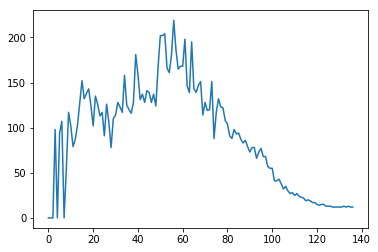

In [185]:
plt.plot(integered)

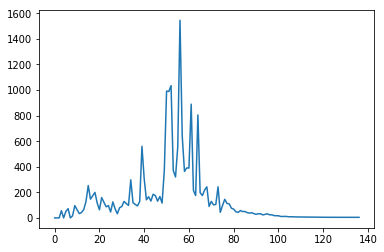

In [186]:
plt.plot(output)